In [ ]:
import dask.dataframe as dd
import zipfile
import os

# Define the path to your zipped parquet file
zip_file_path = "checkpoint_datacleaning.zip"

# Define the extraction directory
extract_dir = "/content/extracted_parquet"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the parquet file from the zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Load the parquet file as a Dask DataFrame
parquet_file_path = os.path.join(extract_dir, "checkpoint_datacleaning")
df = dd.read_parquet(parquet_file_path)

df.head()


,abstract_inverted_index,apc_list,apc_paid,authors_count,cited_by_api_url,cited_by_count,cited_by_percentile_year,concepts_count,corresponding_author_ids,corresponding_institution_ids,...,type_crossref,type_id,updated,updated_date,versions,prim_topic,prim_field,prim_domain,prim_score,missing_abstract
0,None,None,None,0,https://api.openalex.org/works?filter=cites:W4...,0,"{'min': 0, 'max': 66}",6,[],[],...,journal-article,https://openalex.org/work-types/article,2025-01-17T01:18:43.637758,2025-01-17T01:18:43.637758,[],<NA>,<NA>,<NA>,NaN,True
1,"{'The': [0, 17, 95, 118], 'development': [1, 8...",None,None,1,https://api.openalex.org/works?filter=cites:W1...,0,"{'min': 0, 'max': 66}",13,['https://openalex.org/A5089955620'],[],...,journal-article,https://openalex.org/work-types/article,2025-01-17T23:08:08.710591,2025-01-17T23:08:08.710591,[],Neonatal Respiratory Health Research,Medicine,Health Sciences,0.9883,False
2,"{'Genotoxicity': [0, 12], 'research': [1, 76],...",None,None,8,https://api.openalex.org/works?filter=cites:W2...,0,"{'min': 0, 'max': 66}",10,[],[],...,journal-article,https://openalex.org/work-types/article,2025-01-17T05:36:57.521683,2025-01-17T05:36:57.521683,[],bioluminescence and chemiluminescence research,"Biochemistry, Genetics and Molecular Biology",Life Sciences,0.5265,False
3,None,None,None,1,https://api.openalex.org/works?filter=cites:W2...,0,"{'min': 0, 'max': 63}",7,['https://openalex.org/A5101726172'],['https://openalex.org/I4210135744'],...,journal-article,https://openalex.org/work-types/article,2025-01-17T11:40:31.631339,2025-01-17T11:40:31.631339,[],Diet and metabolism studies,Medicine,Health Sciences,0.9972,True
4,None,None,None,1,https://api.openalex.org/works?filter=cites:W3...,0,"{'min': 0, 'max': 60}",7,['https://openalex.org/A5016168871'],[],...,journal-article,https://openalex.org/work-types/article,2025-01-17T17:49:01.433374,2025-01-17T17:49:01.433374,[],Pharmacogenetics and Drug Metabolism,"Pharmacology, Toxicology and Pharmaceutics",Life Sciences,0.9786,True


In [2]:
import ast
import re

def process_inverted_index_string(inverted_index_str):
    # Step 1: Convert the string to a Python dictionary safely
    inverted_index = ast.literal_eval(inverted_index_str)

    # Step 2: Build a list of (position, word) pairs
    position_word_pairs = []
    for word, positions in inverted_index.items():
        for pos in positions:
            position_word_pairs.append((pos, word))

    # Step 3: Sort by position
    position_word_pairs.sort()

    # Step 4: Extract words into a list and join into a string
    words = [word for _, word in position_word_pairs]
    text = ' '.join(words)

    # Step 5: Clean up spacing before punctuation
    text = re.sub(r'\s([?.!,;:])', r'\1', text)

    return text


In [ ]:
# Define the path to your zipped model
zip_file_path = "pubmedbert-aging-model.zip"

# Define the extraction directory
extract_dir = "/content/extracted_model"

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract the model from the zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"Model extracted to: {extract_dir}")


Model extracted to: /content/extracted_model


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("extracted_model/")
model = AutoModelForSequenceClassification.from_pretrained("extracted_model/")

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader


# Custom dataset class
class AbstractDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=512):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_len)

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

# Optimized batch prediction function
def batch_predict_aging(texts, model, tokenizer, batch_size=64, max_len=512):
    dataset = AbstractDataset(texts, tokenizer, max_len=max_len)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    all_preds = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Predicting"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            preds = torch.argmax(outputs.logits, dim=1)
            all_preds.extend(preds.cpu().numpy())

    return all_preds


In [ ]:
# Only compute filtered subset with actual abstracts
filtered_df = df[df['missing_abstract'] == False].compute()

# Process and predict in chunks
batch_size = 100_000
all_predictions = []


In [7]:
from tqdm.notebook import tqdm
for start in tqdm(range(0, len(filtered_df), batch_size), desc="Chunking",leave = False):
    end = start + batch_size
    batch_texts = filtered_df['abstract_inverted_index'].iloc[start:end].apply(process_inverted_index_string).tolist()
    preds = batch_predict_aging(batch_texts, model, tokenizer, batch_size=256)
    all_predictions.extend(preds)

# Assign prediction
filtered_df['is_aging'] = all_predictions

filtered_df_dd = dd.from_pandas(filtered_df, npartitions=filtered_df.npartitions)
df = dd.concat([df[df["missing_abstract"] == True], filtered_df_dd], axis=0)

Chunking:   0%|          | 0/16 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/391 [00:00<?, ?it/s]

Predicting:   0%|          | 0/308 [00:00<?, ?it/s]

AttributeError: 'DataFrame' object has no attribute 'npartitions'

In [ ]:
# Repartition to 500 partitions
df_repartitioned = df.repartition(npartitions=500)

# Save to Parquet directly to Google Drive path
df_repartitioned.to_parquet(
    "checkpoint_datacleaning2",
    engine='pyarrow',
    compression='snappy',
    write_index=False
)


In [17]:
# Assign prediction
filtered_df['is_aging'] = all_predictions

df = dd.concat([df[df["missing_abstract"] == True], filtered_df], axis=0)

In [ ]:
df.to_parquet(
    "checkpoint_datacleaning2",
    engine='pyarrow',
    compression='snappy',
    write_index=False
)

In [21]:
df.head()

,abstract_inverted_index,apc_list,apc_paid,authors_count,cited_by_api_url,cited_by_count,cited_by_percentile_year,concepts_count,corresponding_author_ids,corresponding_institution_ids,...,type_id,updated,updated_date,versions,prim_topic,prim_field,prim_domain,prim_score,missing_abstract,is_aging
0,None,None,None,0,https://api.openalex.org/works?filter=cites:W4...,0,"{'min': 0, 'max': 66}",6,[],[],...,https://openalex.org/work-types/article,2025-01-17T01:18:43.637758,2025-01-17T01:18:43.637758,[],<NA>,<NA>,<NA>,NaN,True,NaN
3,None,None,None,1,https://api.openalex.org/works?filter=cites:W2...,0,"{'min': 0, 'max': 63}",7,['https://openalex.org/A5101726172'],['https://openalex.org/I4210135744'],...,https://openalex.org/work-types/article,2025-01-17T11:40:31.631339,2025-01-17T11:40:31.631339,[],Diet and metabolism studies,Medicine,Health Sciences,0.9972,True,NaN
4,None,None,None,1,https://api.openalex.org/works?filter=cites:W3...,0,"{'min': 0, 'max': 60}",7,['https://openalex.org/A5016168871'],[],...,https://openalex.org/work-types/article,2025-01-17T17:49:01.433374,2025-01-17T17:49:01.433374,[],Pharmacogenetics and Drug Metabolism,"Pharmacology, Toxicology and Pharmaceutics",Life Sciences,0.9786,True,NaN
6,None,None,None,2,https://api.openalex.org/works?filter=cites:W3...,0,"{'min': 0, 'max': 60}",5,[],[],...,https://openalex.org/work-types/article,2025-01-17T09:04:08.282477,2025-01-17T09:04:08.282477,[],Traditional Chinese Medicine Studies,Medicine,Health Sciences,0.9960,True,NaN
9,None,None,None,3,https://api.openalex.org/works?filter=cites:W3...,0,"{'min': 0, 'max': 60}",11,[],[],...,https://openalex.org/work-types/article,2025-01-17T14:44:13.147750,2025-01-17T14:44:13.147750,[],Autophagy in Disease and Therapy,Medicine,Health Sciences,0.9991,True,NaN


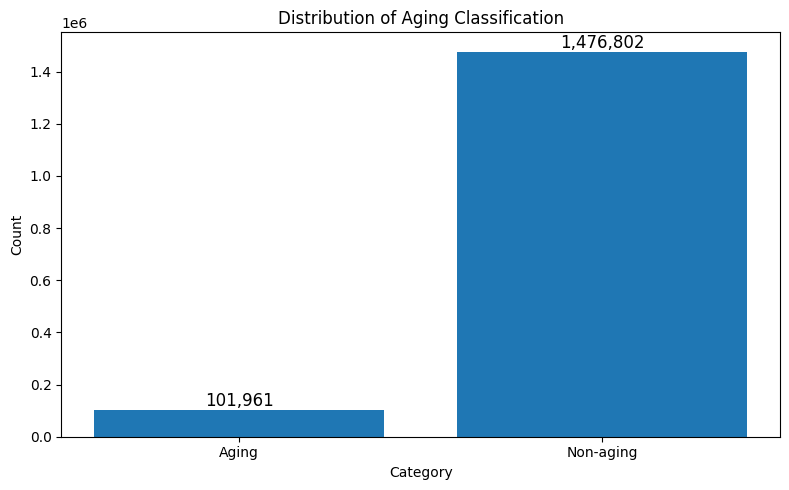

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate value counts, including NaN
value_counts = df['is_aging'].value_counts(dropna=False).compute()

# Map the labels
label_map = {
    0: 'Aging',
    1: 'Non-aging',
    float('NaN'): 'Missing abstract'  # NaN will be handled below
}

# Replace NaN key with string label
labels = []
counts = []
for k, v in value_counts.items():
    if pd.isna(k):
        labels.append('Missing abstract')
    elif k == 0:
        labels.append('Aging')
    elif k == 1:
        labels.append('Non-aging')
    else:
        labels.append(str(k))
    counts.append(v)

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts)

# Add exact count on top of each bar
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{count:,}', ha='center', va='bottom', fontsize=12)

plt.title('Distribution of Aging Classification')
plt.ylabel('Count')
plt.xlabel('Category')
plt.tight_layout()
plt.show()
